In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import tf_keras

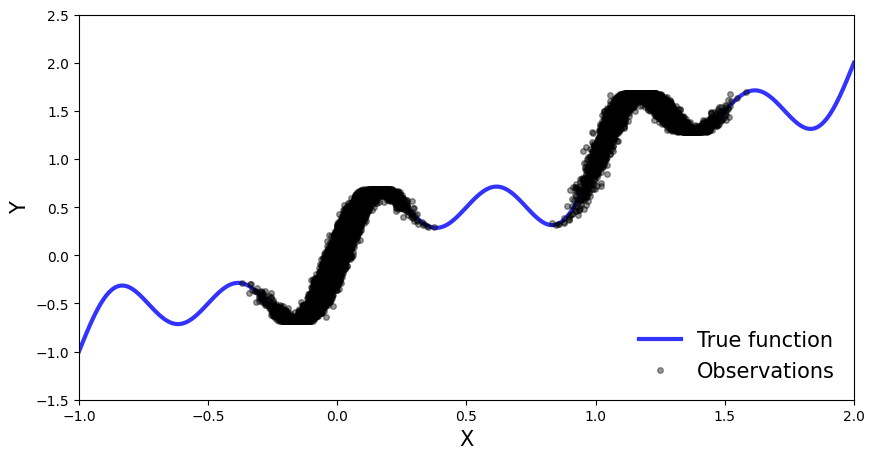

In [139]:
np.random.seed(42+1)

X_train = np.hstack([0.1 * np.random.randn(10000), 0.6 + 0.2 * np.random.randn(0), 1.2 + 0.1 * np.random.randn(10000)])
noise = 0.02 * np.random.randn(X_train.shape[0])
y_train = X_train + 0.3 * np.sin(2 * np.pi * (X_train + noise)) + 0.3 * np.sin(4 * np.pi * (X_train + noise)) + noise

x_true = np.linspace(-1, 2, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

xlims = [-1, 2]
ylims = [-1.5, 2.5]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_true, y_true, 'b-', linewidth=3, label="True function", alpha=0.8)
ax.plot(X_train, y_train, 'ko', markersize=4, label="Observations", alpha=0.4)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=15)
ax.set_ylabel("Y", fontsize=15)
ax.legend(loc=4, fontsize=15, frameon=False)

plt.show()

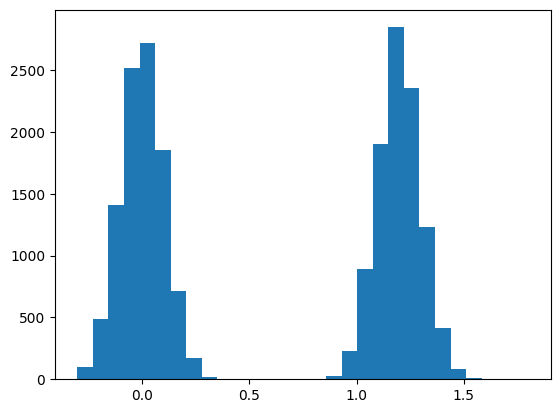

In [140]:
plt.hist(X_train, bins=np.linspace(-0.3, 1.8, 30))
plt.show()

In [178]:
event_shape = [1]
params_size = tfp.layers.MixtureNormal.params_size(3, event_shape)

model = tf_keras.Sequential([
    tf_keras.layers.Dense(128, activation='relu', input_shape=(1,)),
    tf_keras.layers.Dense(128, activation='relu'),
    tf_keras.layers.Dense(128, activation='relu'),
    tf_keras.layers.Dense(params_size),
    tfp.layers.MixtureNormal(3, event_shape)
])

def negloglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=0.001), loss=negloglik)
model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 128)               256       
                                                                 
 dense_71 (Dense)            (None, 128)               16512     
                                                                 
 dense_72 (Dense)            (None, 128)               16512     
                                                                 
 dense_73 (Dense)            (None, 9)                 1161      
                                                                 
 mixture_normal_34 (Mixture  ((None, 1),               0         
 Normal)                      (None, 1))                         
                                                                 
Total params: 34441 (134.54 KB)
Trainable params: 34441 (134.54 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

In [179]:
x_test = np.linspace(-0.5, 1.5, 1000)
y_test = x_test + 0.3 * np.sin(2 * np.pi * x_test) + 0.3 * np.sin(4 * np.pi * x_test)

history = model.fit(X_train,y_train, validation_data=(x_test, y_test), epochs=40, verbose=1)

Epoch 1/40
625/625 [==============================] - 1s 537us/step - loss: -0.4247 - val_loss: 0.8567
Epoch 2/40
625/625 [==============================] - 0s 310us/step - loss: -0.6291 - val_loss: 0.9071
Epoch 3/40
625/625 [==============================] - 0s 309us/step - loss: -0.8651 - val_loss: 0.2385
Epoch 4/40
625/625 [==============================] - 0s 314us/step - loss: -0.9601 - val_loss: 0.4949
Epoch 5/40
625/625 [==============================] - 0s 313us/step - loss: -1.0461 - val_loss: 0.1938
Epoch 6/40
625/625 [==============================] - 0s 307us/step - loss: -1.0642 - val_loss: 0.0480
Epoch 7/40
625/625 [==============================] - 0s 310us/step - loss: -1.1077 - val_loss: -0.2177
Epoch 8/40
625/625 [==============================] - 0s 308us/step - loss: -1.1669 - val_loss: -0.5246
Epoch 9/40
625/625 [==============================] - 0s 314us/step - loss: -1.2051 - val_loss: -0.7747
Epoch 10/40
625/625 [==============================] - 0s 307us/step -

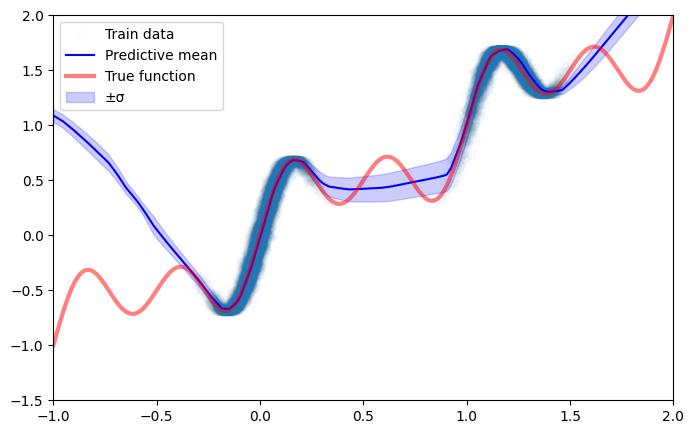

In [181]:
x_test = np.linspace(-1, 2, 1000)
y_test = x_test + 0.3 * np.sin(2 * np.pi * x_test) + 0.3 * np.sin(4 * np.pi * x_test)
y_dist = model(x_test)
y_pred = y_dist.mean().numpy()
y_std = y_dist.stddev().numpy()

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(X_train, y_train, 'o', label='Train data', alpha=0.01)
plt.plot(x_test, y_pred, 'b', label='Predictive mean')
plt.plot(x_test, y_test, 'r', linewidth=3, label="True function", alpha=0.5)
plt.fill_between(x_test.flatten(),
                 (y_pred - y_std).reshape(-1),
                 (y_pred + y_std).reshape(-1),
                 color='blue', alpha=0.2, label='±σ')
plt.ylim(-1.5,2)
plt.xlim(-1, 2)
plt.legend()
plt.show()

In [144]:
tfd = tfp.distributions
tfpl = tfp.layers

batch_num = int(X_train.shape[0] / 128)

scale = X_train.shape[0]


event_shape = [1]
params_size = tfp.layers.MixtureNormal.params_size(1, event_shape)

norm_layer = tf_keras.layers.Normalization(input_shape=(1,))
norm_layer.adapt(X_train.reshape(-1,1))

activation = "tanh"
model = tf_keras.Sequential([
    norm_layer,
    tfpl.DenseFlipout(128, activation=activation,
                      kernel_divergence_fn=lambda q,p,ignore: tfp.distributions.kl_divergence(q, p) / scale,
                      bias_divergence_fn=lambda q,p,ignore: tfp.distributions.kl_divergence(q, p) / scale),
    tfpl.DenseFlipout(128, activation=activation,
                      kernel_divergence_fn=lambda q,p,ignore: tfp.distributions.kl_divergence(q, p) / scale,
                      bias_divergence_fn=lambda q,p,ignore: tfp.distributions.kl_divergence(q, p) / scale),
    tfpl.DenseFlipout(128, activation=activation,
                      kernel_divergence_fn=lambda q,p,ignore: tfp.distributions.kl_divergence(q, p) / scale,
                      bias_divergence_fn=lambda q,p,ignore: tfp.distributions.kl_divergence(q, p) / scale),
    tf_keras.layers.Dense(params_size),
    tfp.layers.MixtureNormal(1, event_shape)
])

def negloglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)



boundaries = [150 * batch_num]
values = [0.001, 0.0001]
learning_schedule = tf_keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

model.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=learning_schedule), loss=negloglik)
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_21 (Normaliz  (None, 1)                 3         
 ation)                                                          
                                                                 
 dense_flipout_63 (DenseFli  (None, 128)               384       
 pout)                                                           
                                                                 
 dense_flipout_64 (DenseFli  (None, 128)               32896     
 pout)                                                           
                                                                 
 dense_flipout_65 (DenseFli  (None, 128)               32896     
 pout)                                                           
                                                                 
 dense_53 (Dense)            (None, 3)               

In [145]:
x_test = np.linspace(-0.5, 1.5, 1000)
y_test = x_test + 0.3 * np.sin(2 * np.pi * x_test) + 0.3 * np.sin(4 * np.pi * x_test)


loss_log_dir = "../logs/fit/loss/BNN"
history = model.fit(X_train,y_train, validation_data=(x_test, y_test), epochs=1000, verbose=1, batch_size=128,
                    callbacks=[tf_keras.callbacks.TensorBoard(log_dir=loss_log_dir, histogram_freq=1), tf_keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                                                                                        mode='min',
                                                                                                                                        patience=30,
                                                                                                                                        verbose=1,
                                                                                                                                        start_from_epoch=100,
                                                                                                                                        restore_best_weights=True)])

Epoch 1/1000
157/157 [==============================] - 1s 3ms/step - loss: 4.3283 - val_loss: 7.3195
Epoch 2/1000
157/157 [==============================] - 0s 1ms/step - loss: 3.9070 - val_loss: 7.7142
Epoch 3/1000
157/157 [==============================] - 0s 1ms/step - loss: 3.7226 - val_loss: 5.8849
Epoch 4/1000
157/157 [==============================] - 0s 1ms/step - loss: 3.5901 - val_loss: 5.5369
Epoch 5/1000
157/157 [==============================] - 0s 1ms/step - loss: 3.4739 - val_loss: 5.3536
Epoch 6/1000
157/157 [==============================] - 0s 1ms/step - loss: 3.3878 - val_loss: 4.8959
Epoch 7/1000
157/157 [==============================] - 0s 1ms/step - loss: 3.2959 - val_loss: 5.2652
Epoch 8/1000
157/157 [==============================] - 0s 1ms/step - loss: 3.2131 - val_loss: 5.1671
Epoch 9/1000
157/157 [==============================] - 0s 1ms/step - loss: 3.1319 - val_loss: 5.4942
Epoch 10/1000
157/157 [==============================] - 0s 1ms/step - loss: 3.046

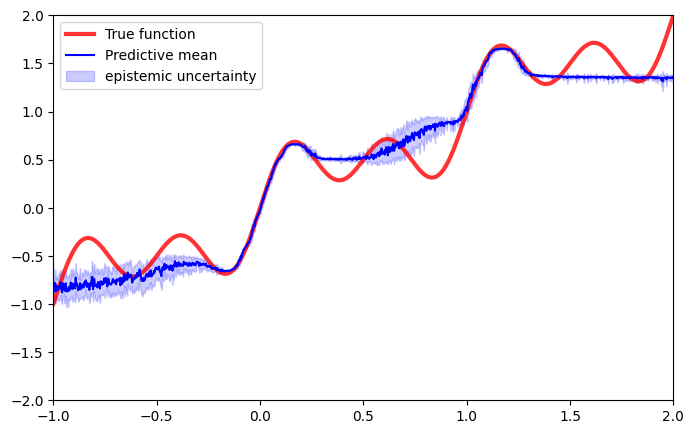

In [160]:
x_test = np.linspace(-1, 2, 1000)
y_test = x_test + 0.3 * np.sin(2 * np.pi * x_test) + 0.3 * np.sin(4 * np.pi * x_test)

means = []
variances = []
for _ in range(20):
    dist = model(x_test)
    means.append(dist.mean().numpy())
    variances.append(dist.variance().numpy())

y_mean = np.array(means).mean(axis=0)
y_aleatoric_variance = np.array(variances).mean(axis=0)
y_epistemic_variance = np.array(means).std(axis=0) ** 2
y_std = np.sqrt(y_epistemic_variance)


import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
# plt.plot(X_train, y_train, 'kx', label='Train data')
plt.plot(x_test, y_test, 'r', linewidth=3, label="True function", alpha=0.8)
plt.plot(x_test, y_mean, color='b', label='Predictive mean')
plt.fill_between(x_test.flatten(),
                 (y_mean - 1 * y_std).reshape(-1),
                 (y_mean + 1 * y_std).reshape(-1),
                 color='blue', alpha=0.2, label='epistemic uncertainty')
plt.ylim(-2,2)
plt.xlim(-1, 2)
plt.legend()
plt.show()

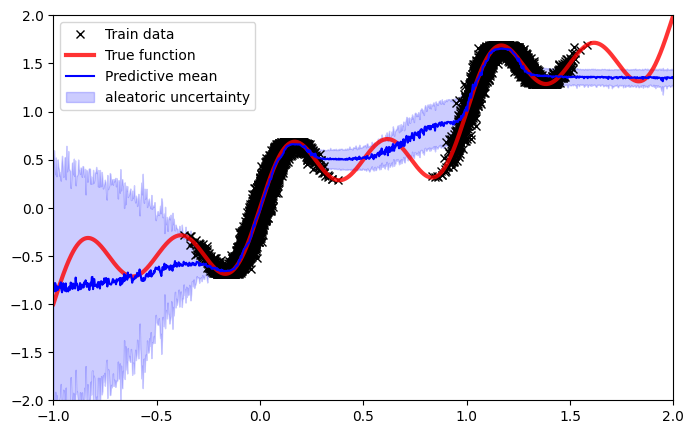

In [162]:
## NIE WIEM CZY TO POPRAWNE, WYDAJE MI SIĘ, ŻE EPISTEMIC TEŻ TU WYCHODZI

y_std = np.sqrt(y_aleatoric_variance)

plt.figure(figsize=(8,5))
plt.plot(X_train, y_train, 'kx', label='Train data')
plt.plot(x_test, y_test, 'r', linewidth=3, label="True function", alpha=0.8)
plt.plot(x_test, y_mean, color='b', label='Predictive mean')
plt.fill_between(x_test.flatten(),
                 (y_mean - 1 * y_std).reshape(-1),
                 (y_mean + 1 * y_std).reshape(-1),
                 color='blue', alpha=0.2, label='aleatoric uncertainty')
plt.ylim(-2,2)
plt.xlim(-1, 2)
plt.legend()
plt.show()

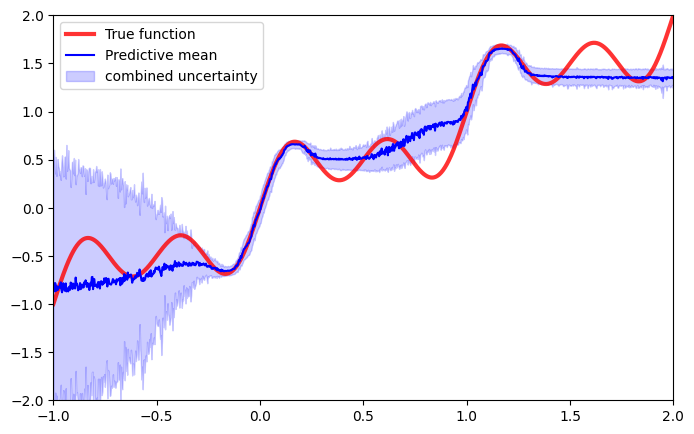

In [161]:
y_std = np.sqrt(y_epistemic_variance + 1.0 * y_aleatoric_variance)
plt.figure(figsize=(8,5))
# plt.plot(X_train, y_train, 'kx', label='Train data')
plt.plot(x_test, y_test, 'r', linewidth=3, label="True function", alpha=0.8)
plt.plot(x_test, y_mean, color='b', label='Predictive mean')
plt.fill_between(x_test.flatten(),
                 (y_mean - 1 * y_std).reshape(-1),
                 (y_mean + 1 * y_std).reshape(-1),
                 color='blue', alpha=0.2, label='combined uncertainty')
plt.ylim(-2,2)
plt.xlim(-1, 2)
plt.legend()
plt.show()

In [21]:
## ---- REDSHIFT DATA ----

In [197]:
import importlib

import data_frame
import models

In [376]:
importlib.reload(data_frame)
importlib.reload(models)

filePath = "../KiDS-DR5-WCScut_x_DESI-DR1-small.fits"
df = data_frame.DataFrame(filePath, "QSO", data_frame.MaxFiller())

config = {}
model = models.MLModelContext(strategy=models.BayesianNN(df, config))

/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_vari

In [377]:
model.train()

Epoch 1/1000
889/889 [==============================] - 5s 4ms/step - loss: 9.0585 - val_loss: 8.3339
Epoch 2/1000
889/889 [==============================] - 3s 4ms/step - loss: 8.2290 - val_loss: 8.1297
Epoch 3/1000
889/889 [==============================] - 3s 4ms/step - loss: 8.0620 - val_loss: 8.0023
Epoch 4/1000
889/889 [==============================] - 3s 4ms/step - loss: 7.9398 - val_loss: 7.8830
Epoch 5/1000
889/889 [==============================] - 3s 4ms/step - loss: 7.8259 - val_loss: 7.7655
Epoch 6/1000
889/889 [==============================] - 3s 4ms/step - loss: 7.7156 - val_loss: 7.6712
Epoch 7/1000
889/889 [==============================] - 3s 4ms/step - loss: 7.6240 - val_loss: 7.5824
Epoch 8/1000
889/889 [==============================] - 3s 4ms/step - loss: 7.5384 - val_loss: 7.4927
Epoch 9/1000
889/889 [==============================] - 3s 4ms/step - loss: 7.4609 - val_loss: 7.4115
Epoch 10/1000
889/889 [==============================] - 3s 4ms/step - loss: 7.381

KeyboardInterrupt: 

In [204]:
scaler = model.strategy.scaler
X_test, y_test = df.get_random_test_dataset()
X_faint, y_faint = df.get_faint_test_dataset()
X_test = scaler.transform(X_test)
X_faint = scaler.transform(X_faint)

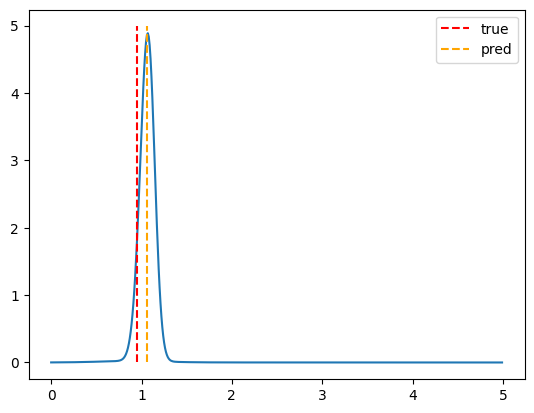

Epistemic error: 0.03
Aleatoric error: 0.10


In [367]:
sample = 4
probs = []
means = []
variances = []
for _ in range(8):
    dist = model.strategy.network(X_faint[sample:sample+1])
    points = np.arange(0,5,0.01)
    log_prob = [dist.log_prob(point) for point in points]
    log_prob = np.array(log_prob)
    prob = np.exp(log_prob)
    probs.append(prob)
    means.append(dist.mean())
    variances.append(dist.variance())

probs = np.array(probs).mean(axis=0)
mean = np.array(means).mean(axis=0)

plt.plot(points, probs)
plt.vlines(x=y_faint[sample:sample+1], ymin=0, ymax=probs.max() + 0.1, color="r", linestyles="dashed", label="true")
plt.vlines(x=mean, ymin=0, ymax=probs.max() + 0.1, color="orange", linestyles="dashed", label="pred")
plt.legend()
plt.show()

print(f"Epistemic error: {np.array(means).std(axis=0).item():.2f}")
print(f"Aleatoric error: {np.sqrt(np.array(variances).mean(axis=0).item()):.2f}")